## Herring Price Prediction using ML
### This notebook uses various ML models to predict herring prices

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
# import visuals
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# load data
train_data = pd.read_excel('data/herring_price_train.xlsx')
test_data = pd.read_excel('data/herring_price_test.xlsx')

In [3]:
train_data.head()

Feature1  Feature2 Feature3   Feature4  Feature5  Feature6  Feature7  \
0  3.838564  2.625122        A  Apartment  3.670953  3.509257  2.496714   
1  4.058313  3.729892        B  Apartment  4.313421  5.426603  2.234153   
2  2.564393  4.076637        C      House  3.505964  5.409845  2.469474   
3  4.083568  5.553960        B      House       NaN  6.003280  2.241962   
4  4.798380  4.472426        A  Apartment  5.648202  4.204247  3.012831   

   Feature8  Feature9  Feature10        Price  
0  2.138264  2.647689   3.523030   604.626580  
1  2.234137       NaN   2.767435   965.572801  
2  2.542560  2.463418   2.465730   623.969085  
3  3.913280  3.724918   2.562288  2270.045340  
4  2.314247  2.908024        NaN  1958.455367

We have 10 features:
- 1-2,5-10 are numeric features
- 3-4 are categorical features

In [4]:
train_data.describe().transpose()

count         mean         std          min         25%  \
Feature1    970.0     5.299010   31.986071     1.201504    3.592592   
Feature2    970.0     3.519229   32.269986 -1000.000000    3.865050   
Feature5    965.0     5.220990   32.071981     1.287018    3.477981   
Feature6    969.0     4.658473    1.014979     1.511661    3.939879   
Feature7    971.0     2.764098    0.586462     2.000528    2.296842   
Feature8    973.0     1.780509   32.154383 -1000.000000    2.326696   
Feature9    966.0     2.801546    0.611611     2.000207    2.324811   
Feature10   965.0     2.812615    0.601790     2.000683    2.330789   
Price      1000.0  1059.096071  585.641730   164.392959  628.212162   

                  50%          75%          max  
Feature1     4.253486     4.918534  1000.000000  
Feature2     4.563057     5.209897     7.738834  
Feature5     4.208140     4.855434  1000.000000  
Feature6     4.632781     5.361547     7.503020  
Feature7     2.638051     3.087333     5.243093  
Feature8     2.677745     3.169590     5.852731  
Feature9     2.652079     3.179404     5.241267  
Feature10    2.691908     3.189667     5.926238  
Price      942.850102  1347.441038  3905.449113

Features 1,2,5,8 has unreasonable min or max values

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature1   970 non-null    float64
 1   Feature2   970 non-null    float64
 2   Feature3   1000 non-null   object 
 3   Feature4   1000 non-null   object 
 4   Feature5   965 non-null    float64
 5   Feature6   969 non-null    float64
 6   Feature7   971 non-null    float64
 7   Feature8   973 non-null    float64
 8   Feature9   966 non-null    float64
 9   Feature10  965 non-null    float64
 10  Price      1000 non-null   float64
dtypes: float64(9), object(2)
memory usage: 86.1+ KB


- The category features has no missing values
- Some values are missing from the numeric features

### Handeling outliers and missing values

In [6]:
# Removing outliers
train_data = train_data.replace(1000, pd.NA)
train_data = train_data.replace(-1000, pd.NA)
train_data.describe()

Feature6    Feature7    Feature9   Feature10        Price
count  969.000000  971.000000  966.000000  965.000000  1000.000000
mean     4.658473    2.764098    2.801546    2.812615  1059.096071
std      1.014979    0.586462    0.611611    0.601790   585.641730
min      1.511661    2.000528    2.000207    2.000683   164.392959
25%      3.939879    2.296842    2.324811    2.330789   628.212162
50%      4.632781    2.638051    2.652079    2.691908   942.850102
75%      5.361547    3.087333    3.179404    3.189667  1347.441038
max      7.503020    5.243093    5.241267    5.926238  3905.449113

Let's look at the pairplot to see correlation between price and the features

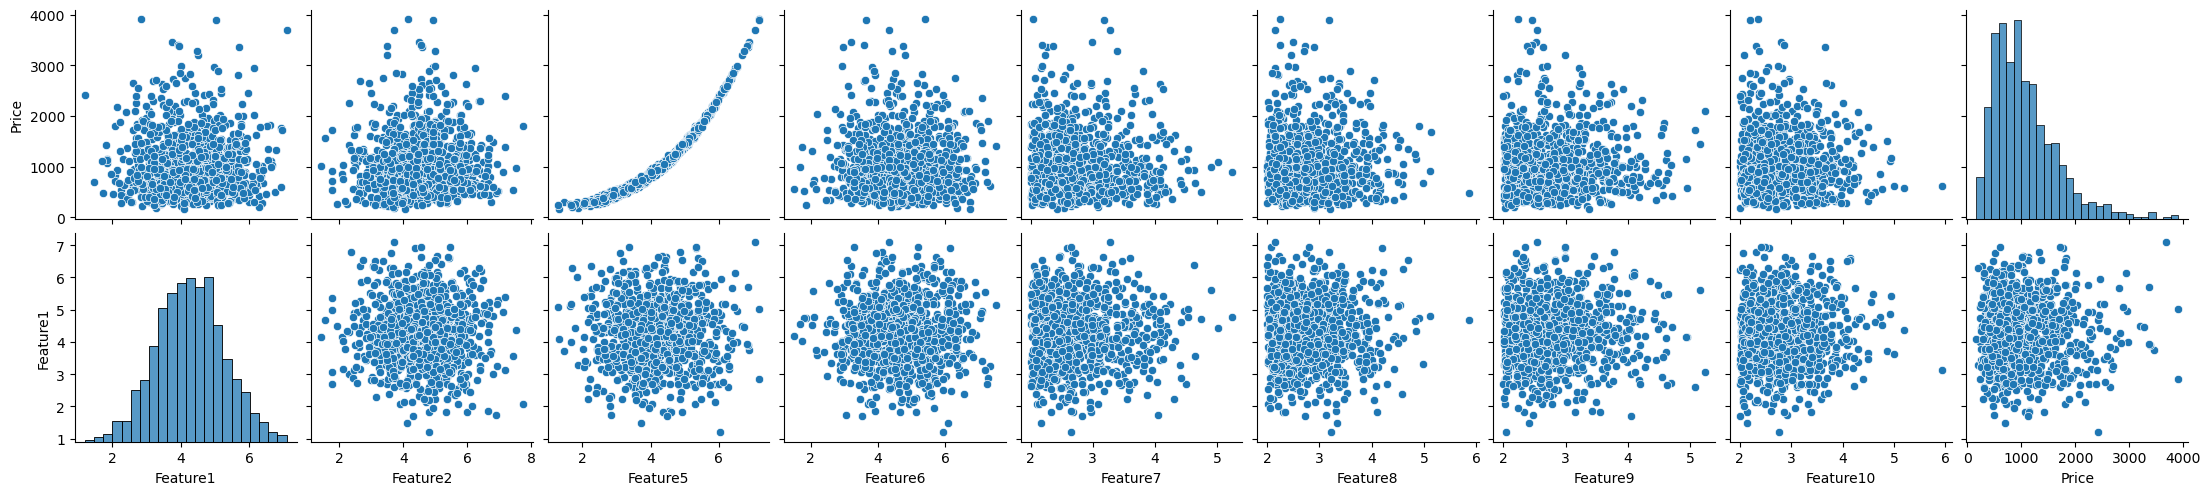

In [7]:
sns.pairplot(train_data,
    y_vars=["Price", "Feature1"])


Feature 5 has a positive and definitive polynomial correlation with the target (price), we can use it to complete the missing values of feature 5

In [8]:
# using polynomial regression to predict feature 5 based on price
train_data_f5 = train_data.dropna()
X = train_data_f5[["Price"]]
y = train_data_f5["Feature5"]

# finding the best polynomial degree for feature 5
best_degree = 0
best_mae = 1000000
for d in range(1, 10):
    poly = preprocessing.PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    if mae < best_mae:
        best_mae = mae
        best_degree = d
        best_poly_f5 = model

print(f"Best degree: {best_degree}, MAE: {best_mae}")


Best degree: 4, MAE: 0.078788674788141


In [9]:
# predicting the missing values in feature 5 using the best model
train_data_f5 = train_data[train_data["Feature5"].isna()]
X = train_data_f5[["Price"]]
poly = preprocessing.PolynomialFeatures(degree=best_degree)
X_poly = poly.fit_transform(X)

train_data.loc[train_data["Feature5"].isna(), "Feature5"] = best_poly_f5.predict(X_poly)

Now we can look again at the pairplot to see how the completion affected the feature5 to price correlation

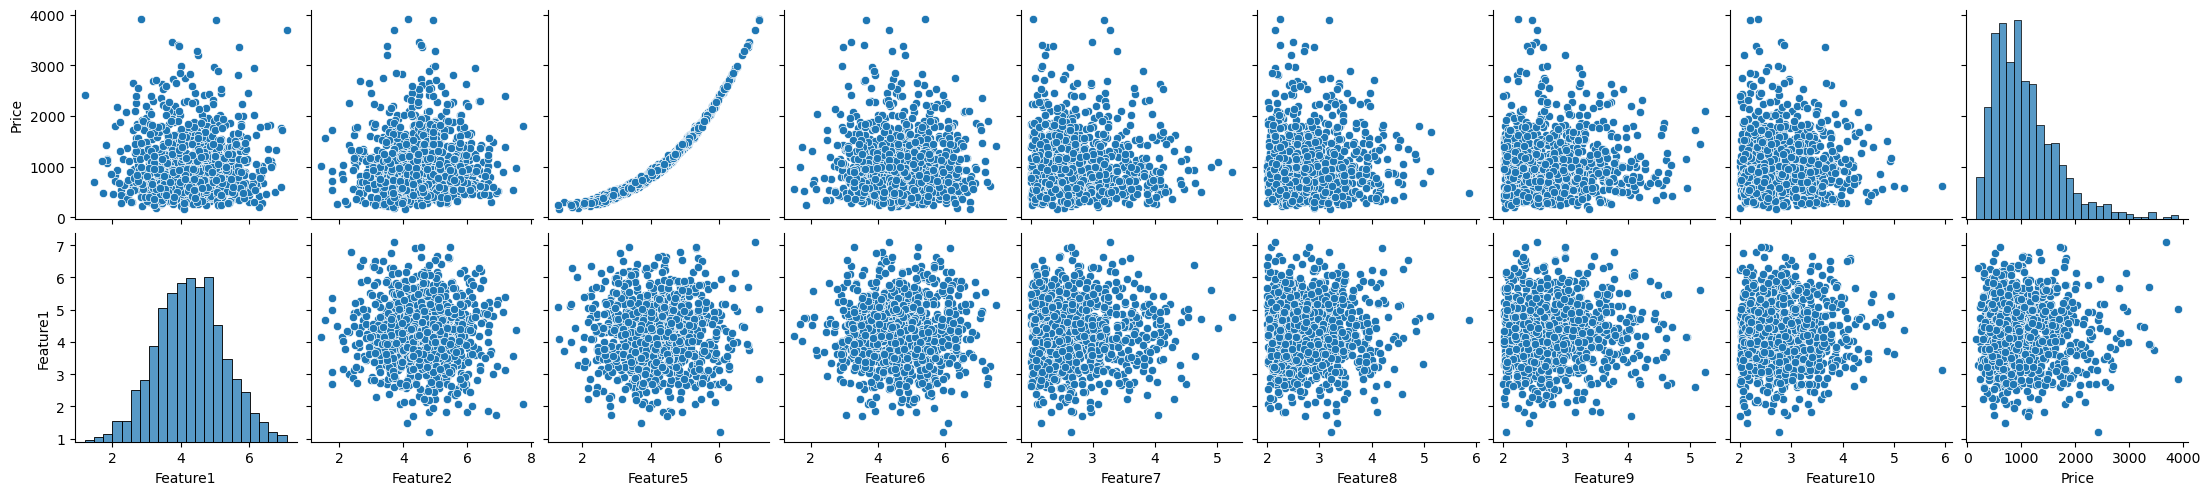

In [10]:
sns.pairplot(train_data,
    y_vars=["Price", "Feature1"])

Let's now look at the complete pairplot to indentify correlation among the features

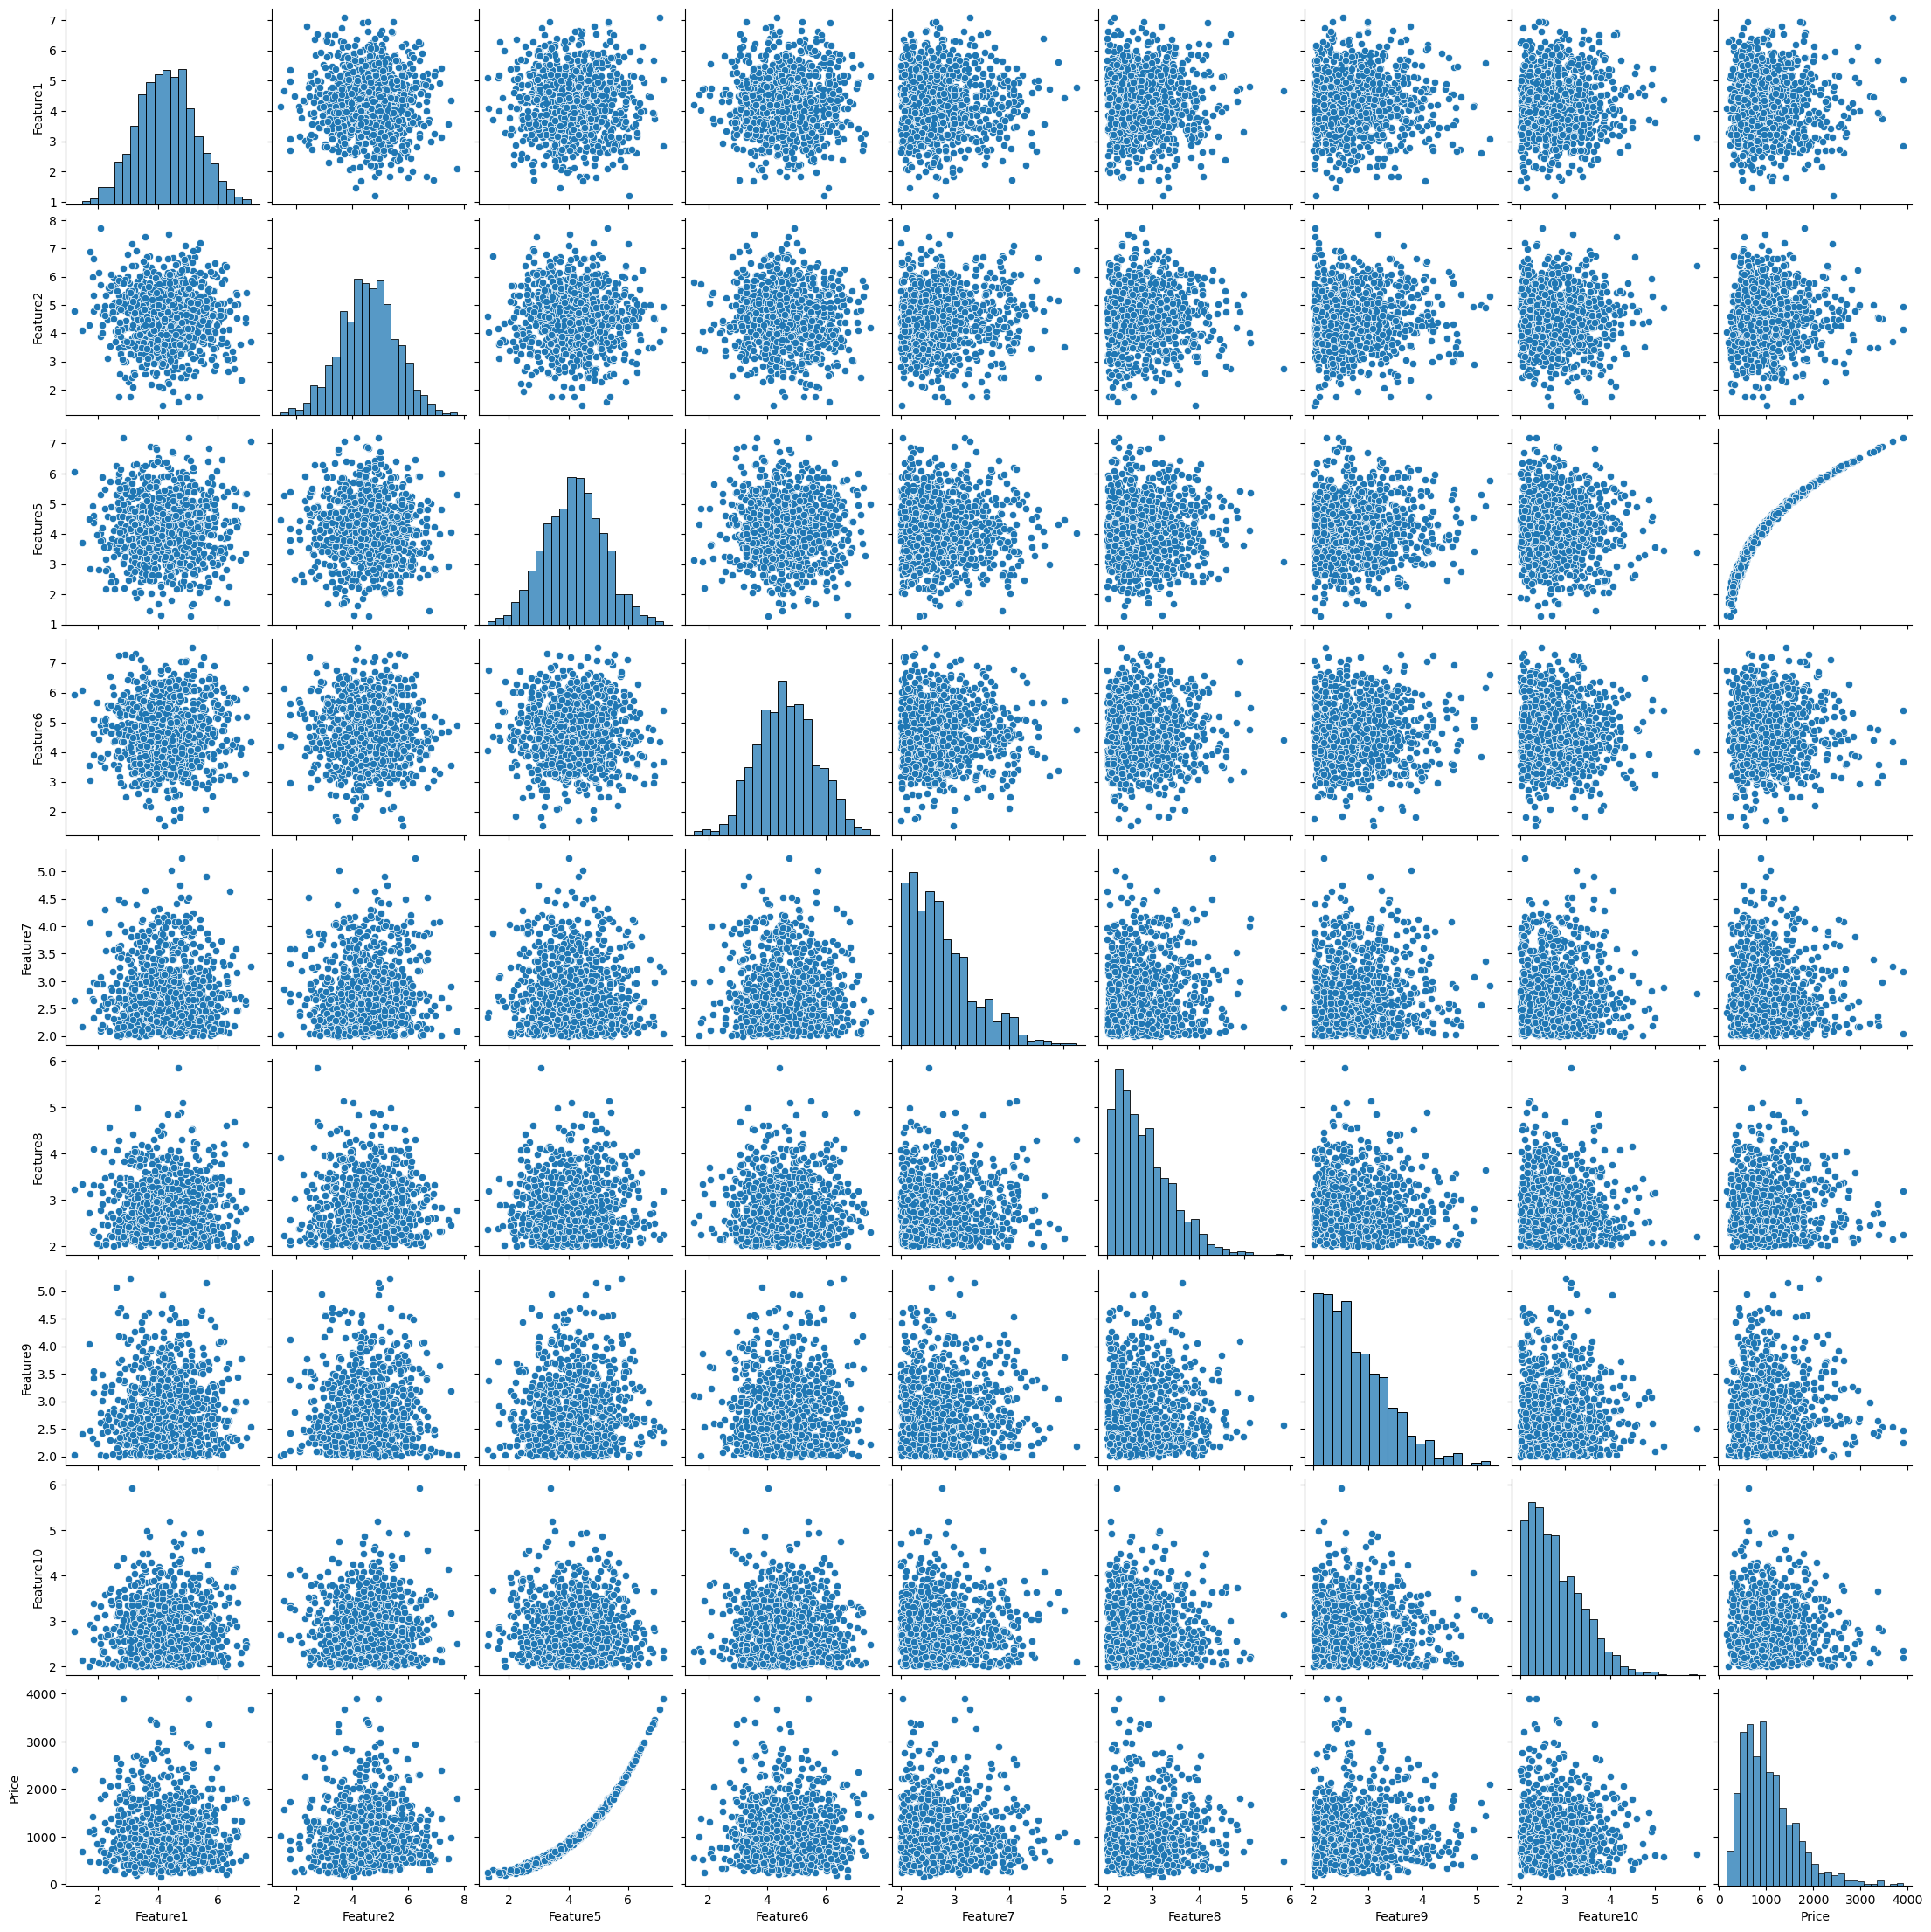

In [11]:
sns.pairplot(train_data)

It looks like there's no correlation among the features. Let's comlpete the missing values by median or average and plot the histogram plots to descide which to use.

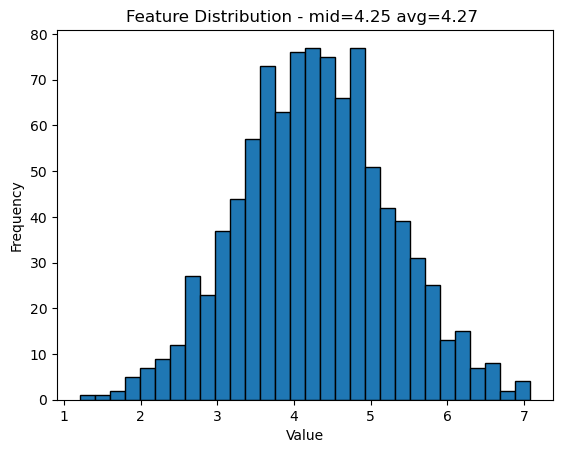

In [12]:
plt.hist(train_data.loc[train_data['Feature1'].notnull(), 'Feature1'], bins=30, edgecolor='black')
plt.title(f"Feature Distribution - mid={train_data['Feature1'].median():.2f} avg={train_data['Feature1'].mean():.2f} ")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [13]:
train_data['Feature1'] = train_data['Feature1'].fillna(train_data['Feature1'].median())

/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_63662/3234844852.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Feature1'] = train_data['Feature1'].fillna(train_data['Feature1'].median())


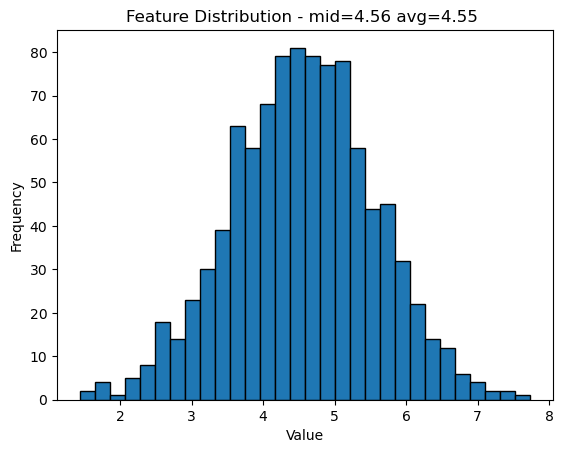

In [14]:
plt.hist(train_data.loc[train_data['Feature2'].notnull(), 'Feature2'], bins=30, edgecolor='black')
plt.title(f"Feature Distribution - mid={train_data['Feature2'].median():.2f} avg={train_data['Feature2'].mean():.2f} ")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [15]:
train_data['Feature2'] = train_data['Feature2'].fillna(train_data['Feature2'].mean())

/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_63662/2871602794.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Feature2'] = train_data['Feature2'].fillna(train_data['Feature2'].mean())


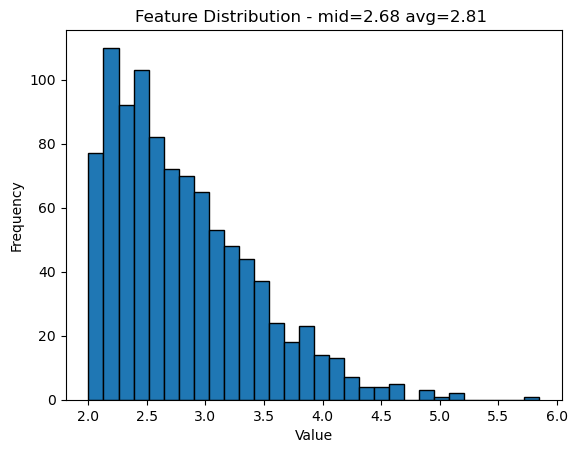

In [16]:
plt.hist(train_data.loc[train_data['Feature8'].notnull(), 'Feature8'], bins=30, edgecolor='black')
plt.title(f"Feature Distribution - mid={train_data['Feature8'].median():.2f} avg={train_data['Feature8'].mean():.2f} ")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [17]:
train_data['Feature8'] = train_data['Feature8'].fillna(train_data['Feature8'].median())

/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_63662/10124467.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data['Feature8'] = train_data['Feature8'].fillna(train_data['Feature8'].median())


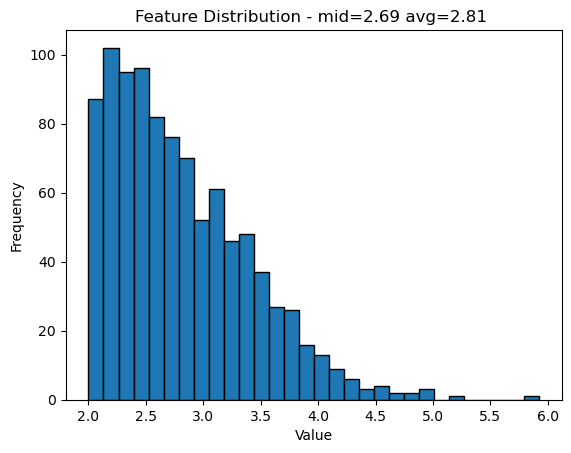

In [18]:
column = 'Feature10'
plt.hist(train_data.loc[train_data[column].notnull(), column], bins=30, edgecolor='black')
plt.title(f"Feature Distribution - mid={train_data[column].median():.2f} avg={train_data[column].mean():.2f} ")
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

#### Completing the categorical feature
Let's see the distribution of feature 3 to descide how to complete it.

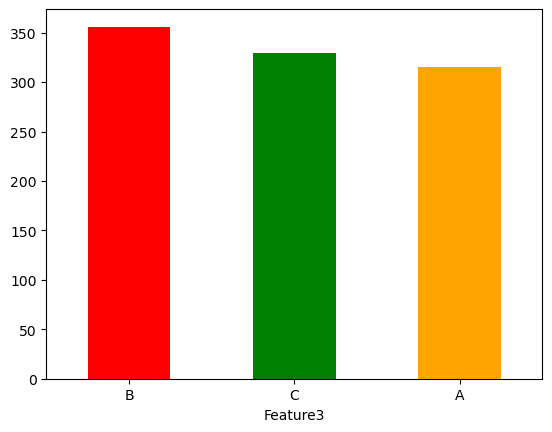

In [19]:
train_data['Feature3'].value_counts().plot(kind = 'bar', color = ['red', 'green',  'orange', 'lightblue'])
plt.xticks(rotation=0)  # Set the x-axis labels to horizontal
plt.show()

Since theres no dominent class, let's see if theres a correlation between it and the price. In order to do it we need to map it to numeric values

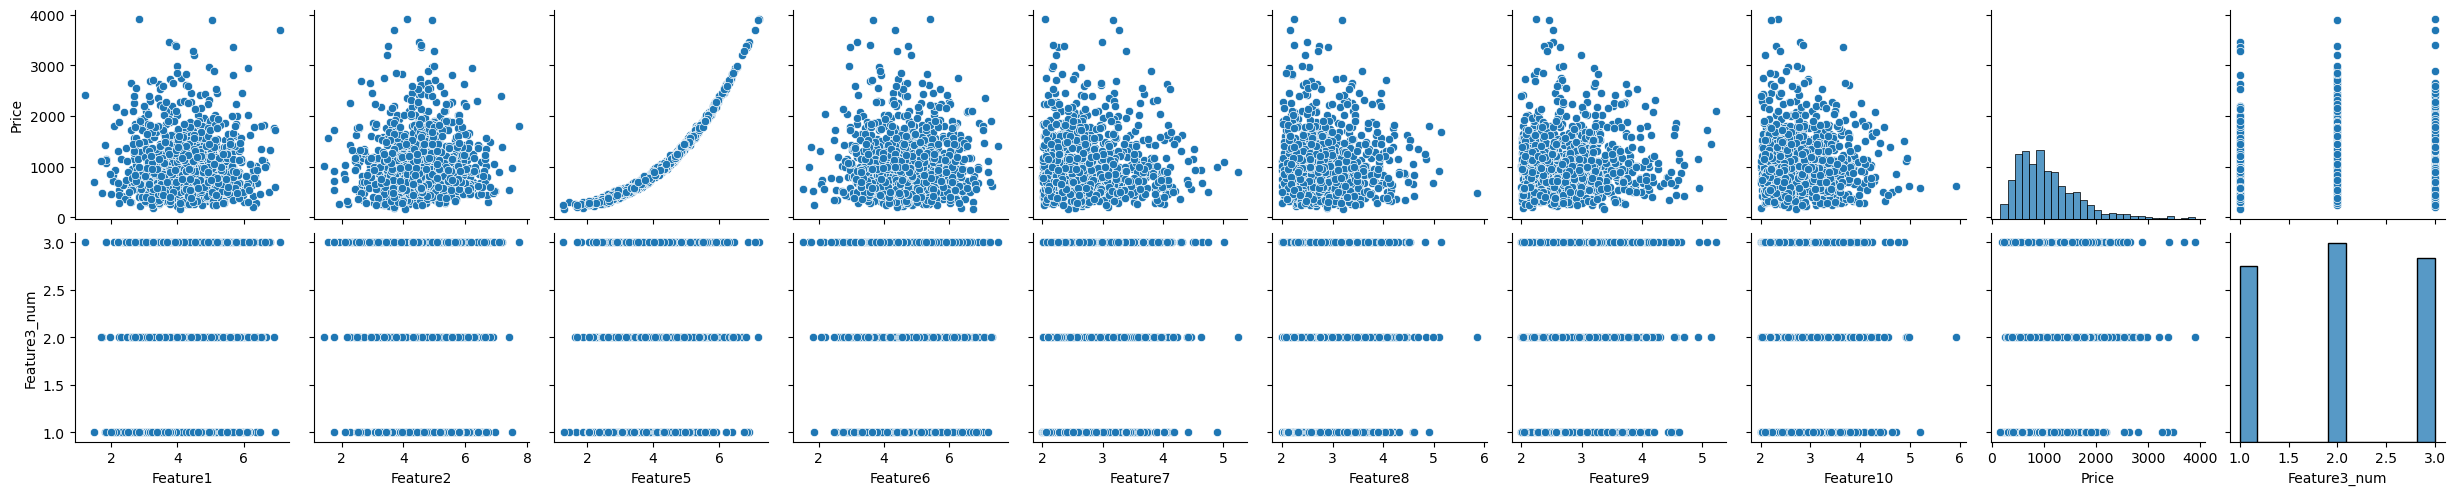

In [20]:
# completing the categorical feature
# mapping the categorical values to numerical values
# A -> 1, B -> 2, C -> 3
lbl_encoder = {'A' : 1, 'B' : 2, 'C' : 3}
train_data['Feature3_num'] = train_data['Feature3'].map(lbl_encoder)

# plotting the pairplot to see the correlation between price and feature3_num
sns.pairplot(train_data,
    y_vars=["Price", "Feature3_num"])

train_data = train_data.drop(columns = ["Feature3_num"])

Since theres also no correlation, lets complete by the discrete distribution of feature 3

In [21]:
# Get the value counts of Feature3 as proportions
value_counts = train_data['Feature3'].value_counts(normalize=True)

# Randomly assign missing values based on the distribution
train_data['Feature3'] = train_data['Feature3'].apply(
   lambda x: x if pd.notnull(x) else np.random.choice(value_counts.index, p=value_counts.values)
)


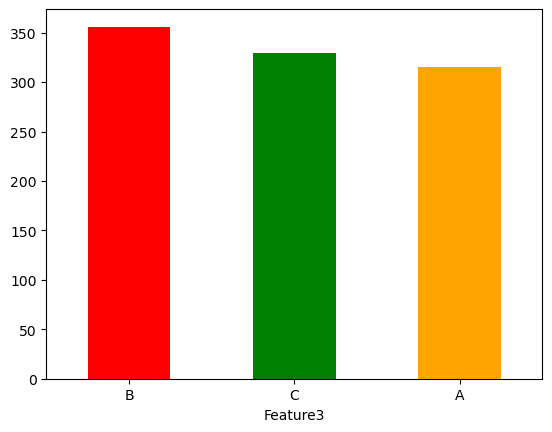

In [22]:
train_data['Feature3'].value_counts().plot(kind = 'bar', color = ['red', 'green',  'orange', 'lightblue'])
plt.xticks(rotation=0)  
plt.show()

In [23]:
for c in train_data.drop(columns = ['Feature3', 'Feature4']).columns:
    train_data[c] = train_data[c].fillna(train_data[c].median())

/var/folders/qn/mj0rz2vn23nbzt4sm0qmhhtw0000gn/T/ipykernel_63662/3906345464.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[c] = train_data[c].fillna(train_data[c].median())


In [24]:
train_data.Price

0       604.626580
1       965.572801
2       623.969085
3      2270.045340
4      1958.455367
          ...     
995    1447.656009
996     391.833785
997     689.902156
998     741.850878
999     903.819213
Name: Price, Length: 1000, dtype: float64

Encoding categorical columns with get_dummies

In [25]:
# all values exist!
# encode Categorical columns - ['Feature3', 'Feature4']
cleaned_df=pd.get_dummies(train_data, columns=["Feature3", 'Feature4'], drop_first=True,dtype = int)


In [26]:
cleaned_df

Feature1  Feature2  Feature5  Feature6  Feature7  Feature8  Feature9  \
0    3.838564  2.625122  3.670953  3.509257  2.496714  2.138264  2.647689   
1    4.058313  3.729892  4.313421  5.426603  2.234153  2.234137  2.652079   
2    2.564393  4.076637  3.505964  5.409845  2.469474  2.542560  2.463418   
3    4.083568  5.553960  5.880361  6.003280  2.241962  3.913280  3.724918   
4    4.798380  4.472426  5.648202  4.204247  3.012831  2.314247  2.908024   
..        ...       ...       ...       ...       ...       ...       ...   
995  5.597513  4.914217  4.928333  6.154906  3.362563  3.640615  5.152057   
996  4.425775  5.366963  2.625381  4.988013  2.242882  4.082099  2.553149   
997  3.698293  5.650094  3.536924  3.279904  3.923446  2.774615  3.689183   
998  5.015617  5.574707  3.737698  4.537751  3.975488  2.751099  4.065083   
999  4.924157  7.099516  4.013262  3.281388  4.077812  2.320298  3.643378   

     Feature10        Price  Feature3_B  Feature3_C  Feature4_House  
0     3.523030   604.626580           0           0               0  
1     2.767435   965.572801           1           0               0  
2     2.465730   623.969085           0           1               1  
3     2.562288  2270.045340           1           0               1  
4     2.691908  1958.455367           0           0               0  
..         ...          ...         ...         ...             ...  
995   3.123494  1447.656009           1           0               1  
996   2.548200   391.833785           1           0               0  
997   2.471264   689.902156           0           1               1  
998   2.028458   741.850878           1           0               0  
999   2.360648   903.819213           0           1               0  

[1000 rows x 12 columns]

In [27]:
cleaned_df.describe().transpose()

count         mean         std         min         25%  \
Feature1        1000.0     4.271888    0.970655    1.201504    3.611932   
Feature2        1000.0     4.554852    0.990427    1.430659    3.888523   
Feature5        1000.0     4.190182    0.998125    1.287018    3.486806   
Feature6        1000.0     4.657677    0.999117    1.511661    3.960320   
Feature7        1000.0     2.760443    0.578275    2.000528    2.307976   
Feature8        1000.0     2.807465    0.599306    2.000314    2.335916   
Feature9        1000.0     2.796464    0.601724    2.000207    2.332063   
Feature10       1000.0     2.808391    0.591570    2.000683    2.348883   
Price           1000.0  1059.096071  585.641730  164.392959  628.212162   
Feature3_B      1000.0     0.356000    0.479055    0.000000    0.000000   
Feature3_C      1000.0     0.329000    0.470085    0.000000    0.000000   
Feature4_House  1000.0     0.515000    0.500025    0.000000    0.000000   

                       50%          75%          max  
Feature1          4.253160     4.903313     7.086228  
Feature2          4.554852     5.186533     7.738834  
Feature5          4.210940     4.855137     7.184316  
Feature6          4.632781     5.326048     7.503020  
Feature7          2.638051     3.067719     5.243093  
Feature8          2.679623     3.148357     5.852731  
Feature9          2.652079     3.154720     5.241267  
Feature10         2.691908     3.161090     5.926238  
Price           942.850102  1347.441038  3905.449113  
Feature3_B        0.000000     1.000000     1.000000  
Feature3_C        0.000000     1.000000     1.000000  
Feature4_House    1.000000     1.000000     1.000000

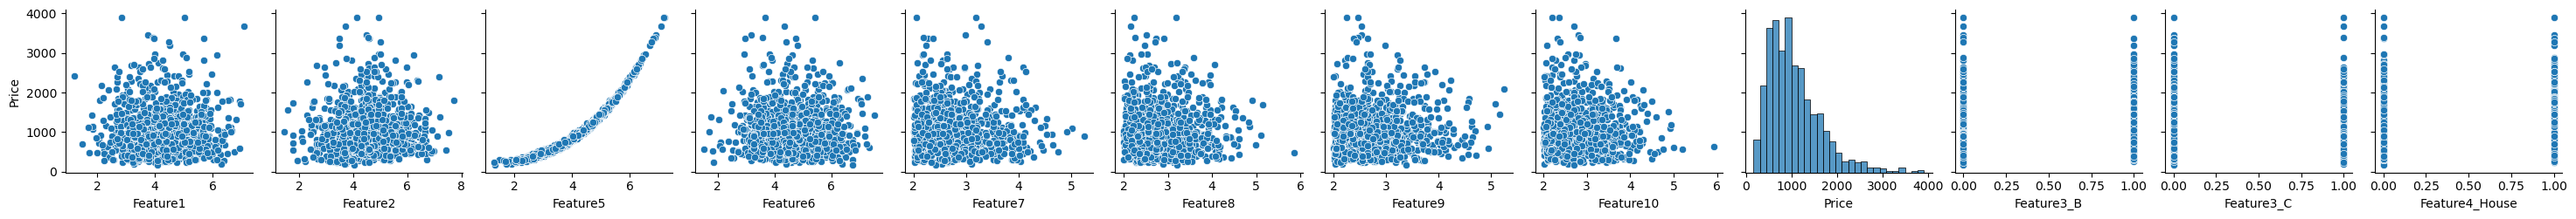

In [28]:
# pairplot
sns.pairplot(cleaned_df,
    y_vars=["Price"])

### Training ML models to predict price
In this notebook, we train Linearl and Polynominal Regiression models, Decision Tree and Random Forest models to predict the price by features 1-10. W evaluate the results with Mean Absolute Error score. (lowest is best)

In [29]:
# Predictions using LR, PR, Trees and randon forest
mae_df = pd.DataFrame(columns = ['LR', 'PR', 'DecisionTree','RandomForest'], index = ['MAE'])
mae_df

LR   PR DecisionTree RandomForest
MAE  NaN  NaN          NaN          NaN

In [30]:
# XY split
x = cleaned_df.drop(columns=['Price'])
y = cleaned_df.Price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

by_score = "neg_mean_absolute_error"

#### Linear Regression

In [31]:
# training LR
reg = LinearRegression()
scores_LR = -cross_val_score(reg, x, y, cv=5, scoring=by_score).mean()
mae_df.loc['MAE', 'LR'] = scores_LR
print(scores_LR)

124.33880250531152


In [32]:
mae_df

LR   PR DecisionTree RandomForest
MAE  124.338803  NaN          NaN          NaN

Feature Importance - which features affected the model most

In [33]:
# Printint LR feature importance
reg.fit(x, y)
coefficients = reg.coef_

print("Featrue importance for Linear Regression from most to least important:")
for i,v in enumerate(coefficients):
    print(f'Feature: {x.columns[i]}, Score: {v:.2f}')

Featrue importance for Linear Regression from most to least important:
Feature: Feature1, Score: 4.66
Feature: Feature2, Score: 23.98
Feature: Feature5, Score: 558.74
Feature: Feature6, Score: -2.60
Feature: Feature7, Score: -4.62
Feature: Feature8, Score: 1.63
Feature: Feature9, Score: -11.45
Feature: Feature10, Score: -1.53
Feature: Feature3_B, Score: 56.21
Feature: Feature3_C, Score: 32.93
Feature: Feature4_House, Score: 51.37


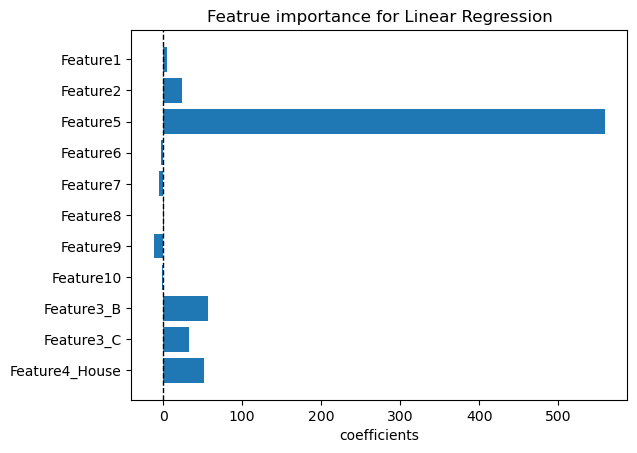

In [34]:
# plotting Featrue importance for Linear Regression
fig, ax = plt.subplots()
y_pos = np.arange(len(x.columns))

ax.barh(y_pos, coefficients, align='center')
ax.set_yticks(y_pos, labels=x.columns)
ax.invert_yaxis() 
ax.set_xlabel('coefficients')
ax.set_title('Featrue importance for Linear Regression')
ax.axvline(0, color='black', linestyle='--', linewidth=1)

plt.show()

### Polynominal Regression 

In [35]:
# training PR
from sklearn.preprocessing import PolynomialFeatures
best_mae = 999
best_d = 1
for d in range(2,10):
    poly_reg_ft = PolynomialFeatures(degree=d)
    x_train_poly_features = poly_reg_ft.fit_transform(x_train)
    x_test_poly_features = poly_reg_ft.transform(x_test)

    poly_reg = LinearRegression()
    poly_reg.fit(x_train_poly_features, y_train)
    y_pred = poly_reg.predict(x_test_poly_features)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"tested d={d}, mae={mae:.2f}")
    if mae < best_mae:
        best_poly_ft = poly_reg_ft
        best_poly_reg = poly_reg
        best_mae = mae
        best_d = d
print(f"** best d={best_d}, mae={best_mae:.2f} **")
mae_df.loc['MAE', 'PR'] = best_mae

tested d=2, mae=16.07
tested d=3, mae=8.51
tested d=4, mae=35.75
tested d=5, mae=29.45
tested d=6, mae=31.98
tested d=7, mae=48.49
tested d=8, mae=82.95
tested d=9, mae=137.50
** best d=3, mae=8.51 **


We found that polynominal regression with 3rd degree (X^3) predicts price best

Feature Importance - which features affected the model most

In [36]:
coefficients = best_poly_reg.coef_
feature_names = x.columns
# Map coefficients to feature names
feature_importance = dict(zip(feature_names, coefficients))

feature_names = best_poly_ft.get_feature_names_out(input_features=feature_names)

importance = {feature: 0 for feature in x.columns}

for name, coef in zip(feature_names, coefficients):
    for feature in x.columns:
        if feature in name:  # Check if the feature is part of the term
            importance[feature] += coef  # Sum absolute coefficients

# Display the aggregated importance
for feature, importance_value in importance.items():
    print(f"{feature}: {importance_value:.4f}")



Feature1: -75.4650
Feature2: 13.7559
Feature5: 26.5441
Feature6: -2.9802
Feature7: 59.1640
Feature8: -52.4352
Feature9: 68.0272
Feature10: -115.6521
Feature3_B: 32.5134
Feature3_C: 34.1726
Feature4_House: 89.0838


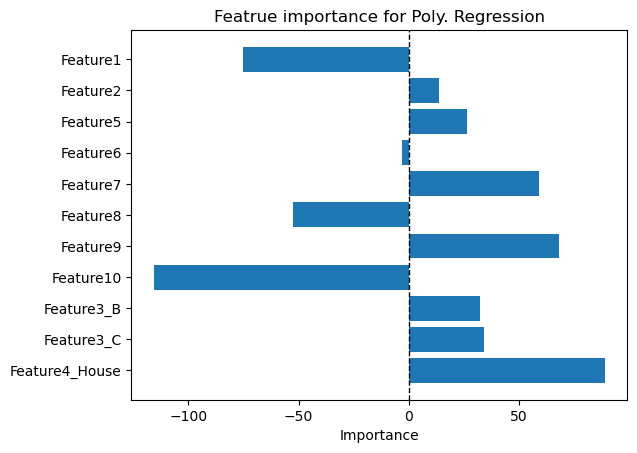

In [37]:
# plot PR feature importance
fig, ax = plt.subplots()
y_pos = np.arange(len(x.columns))

ax.barh(y_pos, importance.values(), align='center')
ax.set_yticks(y_pos, labels=x.columns)
ax.invert_yaxis() 
ax.set_xlabel('Importance')
ax.set_title('Featrue importance for Poly. Regression')
ax.axvline(0, color='black', linestyle='--', linewidth=1)

plt.show()

### Decision Tree

In [38]:
# training DT
best_mae = 999
best_depth = 1

for depth in range(2,30):
    dt_reg = DecisionTreeRegressor(max_depth=depth, random_state = 42)
    mae = -cross_val_score(dt_reg, x, y, cv=5, scoring=by_score).mean()
    #print(f"tested depth={depth}, mae={mae:.2f}")
    if mae < best_mae:
        best_dt_reg = dt_reg
        best_mae = mae
        best_depth = depth
print(f"** best depth={best_depth}, mae={best_mae:.2f} **")
mae_df.loc['MAE', 'DecisionTree'] = best_mae

** best depth=10, mae=33.52 **


Plotting the tree

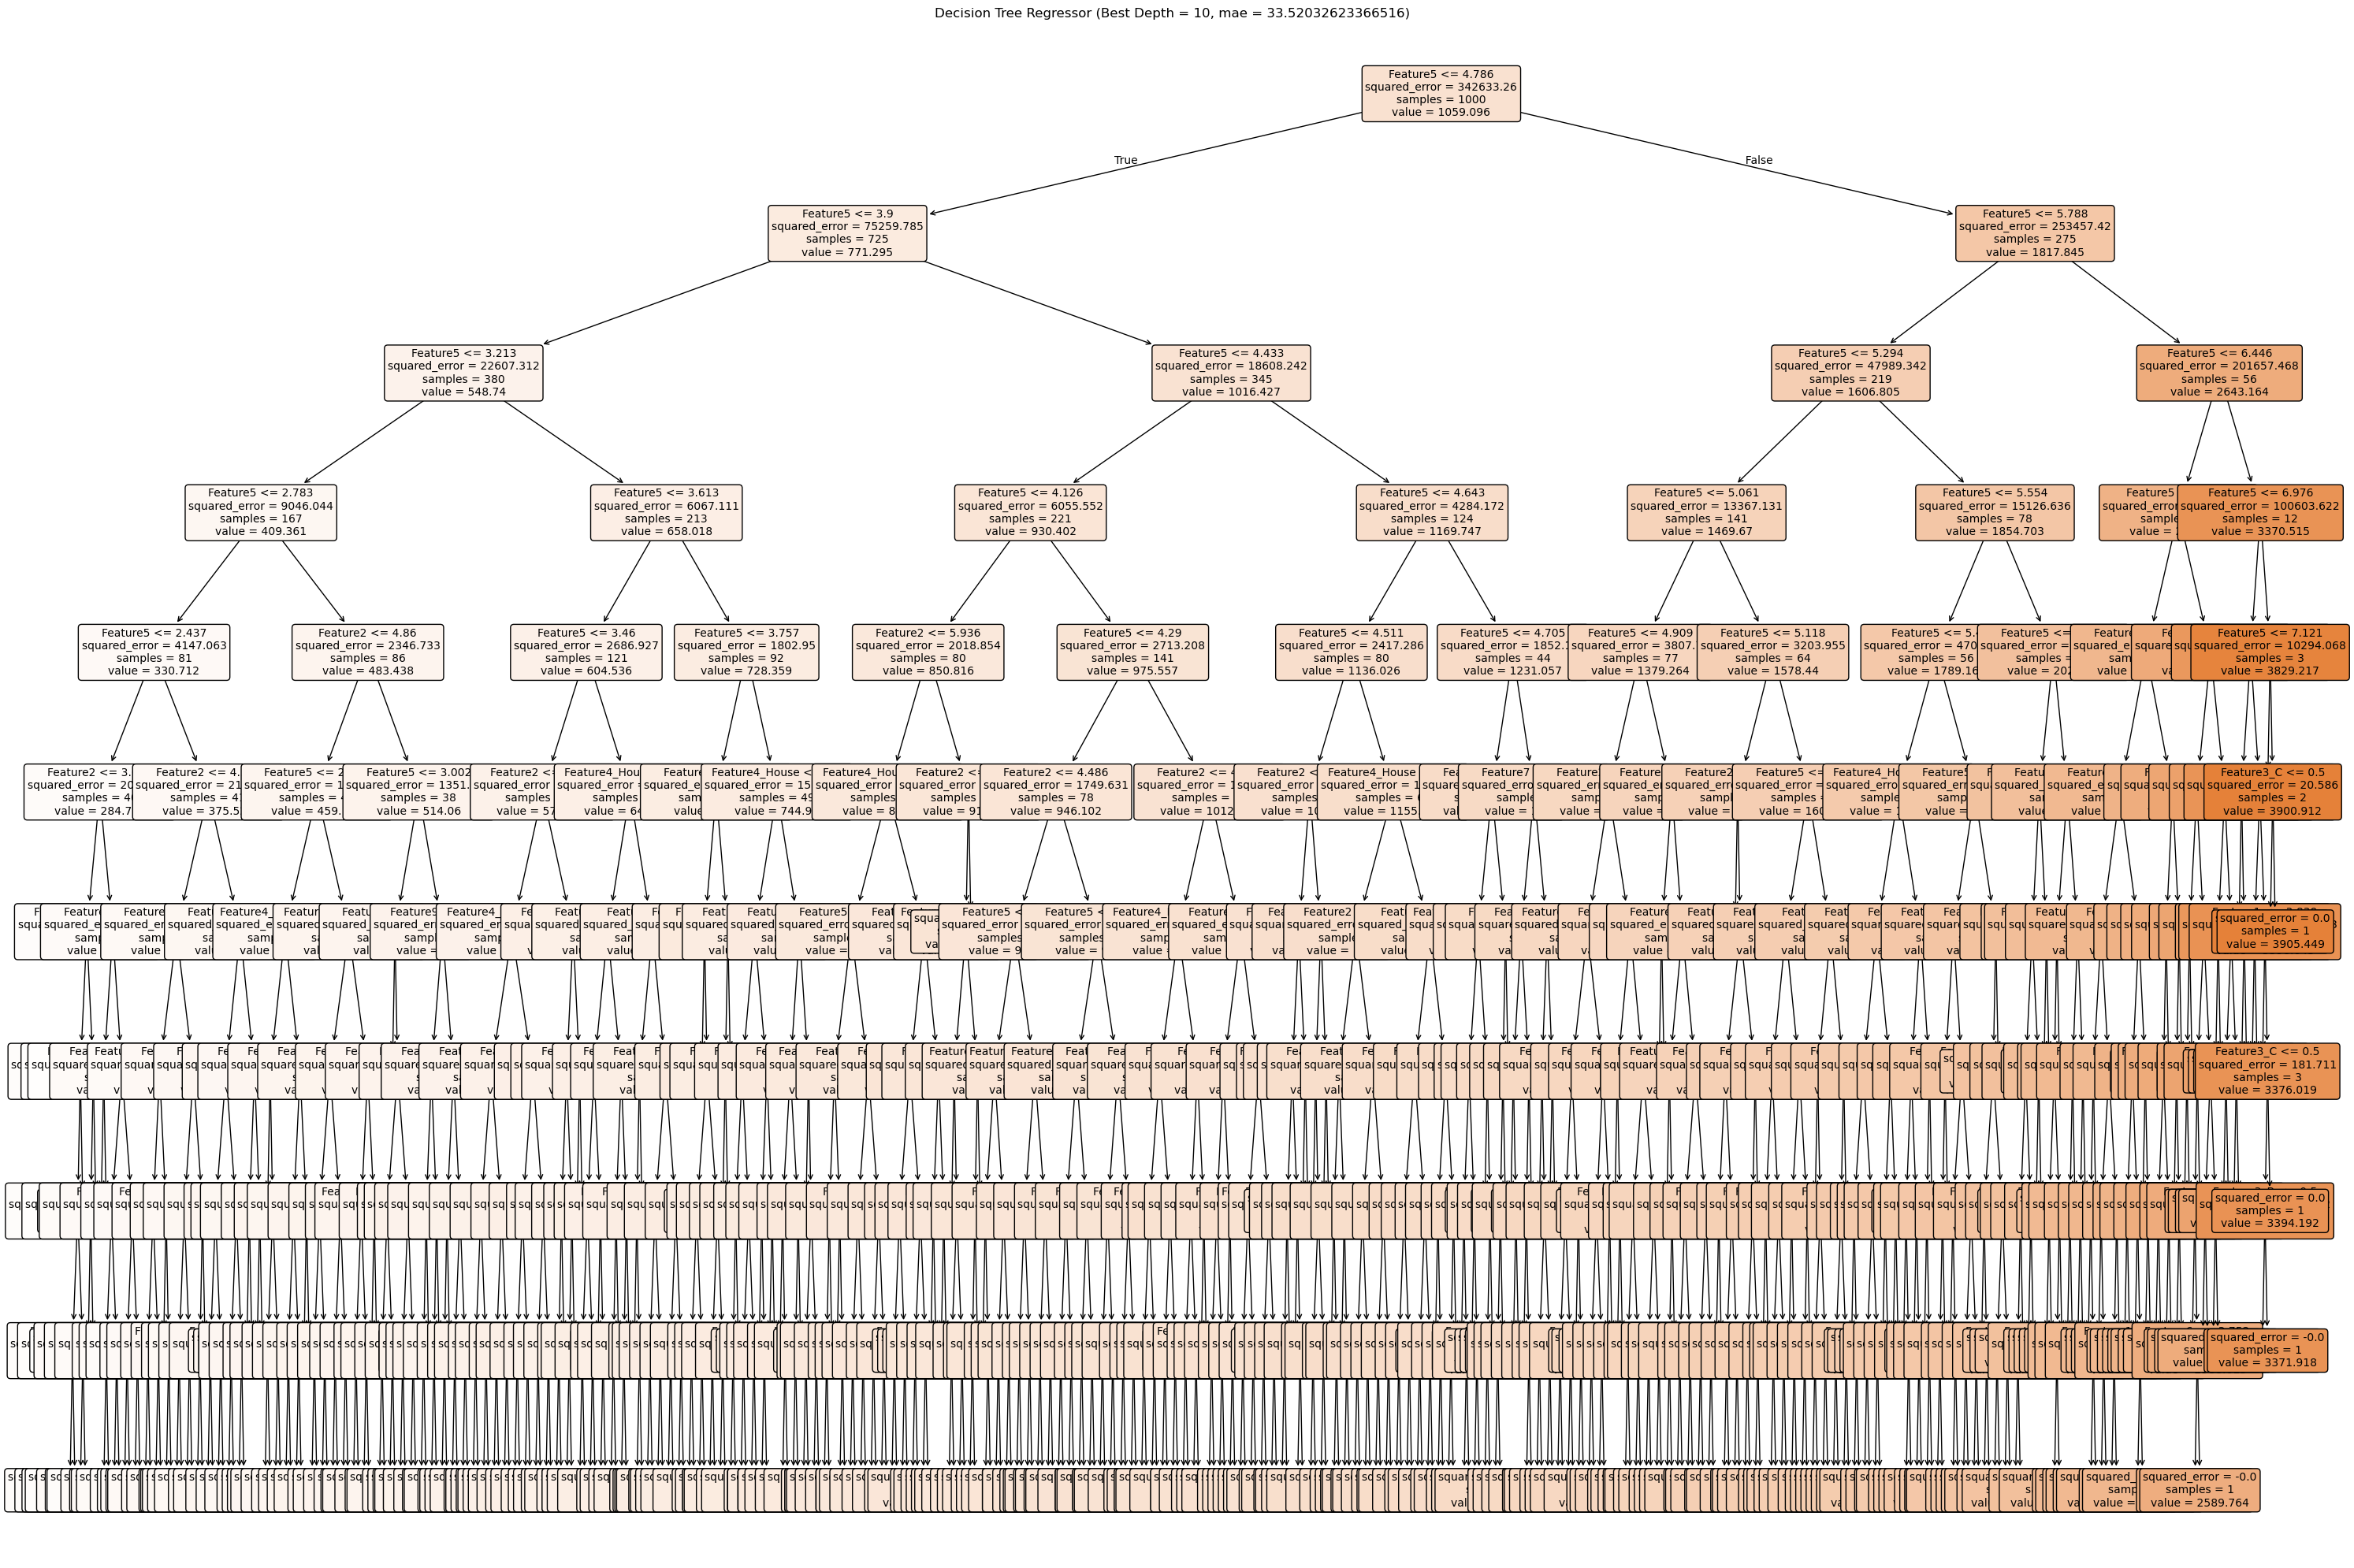

In [39]:
from sklearn import tree
#dt_reg = DecisionTreeRegressor(max_depth=best_depth)
best_dt_reg.fit(x, y)
plt.figure(figsize=(30,20))  # Create a large figure
tree.plot_tree(best_dt_reg, 
               feature_names=x.columns.tolist(),  # Add feature names to the plot
               filled=True,  # Color the nodes
               rounded=True,  # Round the boxes
               fontsize=10)  # Adjust font size for readability

plt.title(f"Decision Tree Regressor (Best Depth = {best_depth}, mae = {best_mae})")
plt.tight_layout()
plt.show()

Feature Importance - which features affected the model most

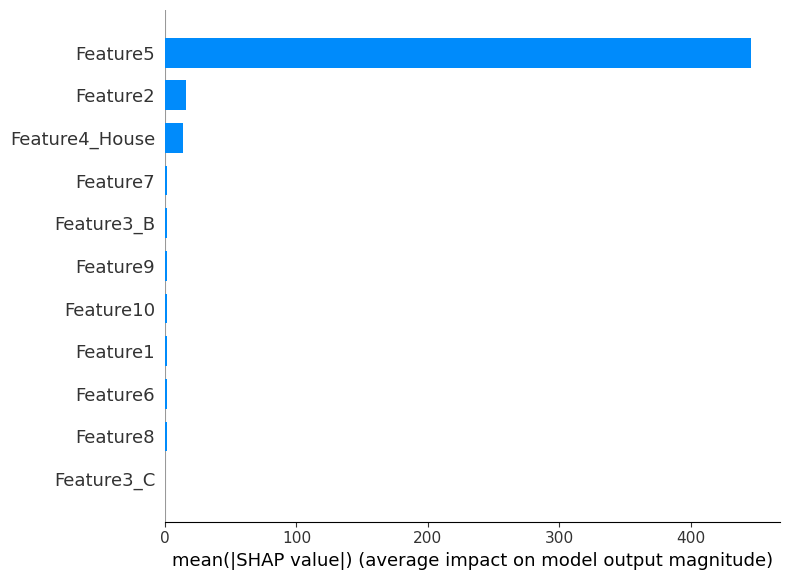

In [40]:
# feature importance using shap
import shap
shap.initjs()
explainer = shap.TreeExplainer(best_dt_reg)
shap_values = explainer.shap_values(x)
shap.summary_plot(shap_values, x, plot_type="bar")

### Random Forest

In [41]:
# random forest
rf_reg = RandomForestRegressor(n_estimators=1000, max_depth=best_depth, random_state = 42)
scores_RF = -cross_val_score(rf_reg, x, y, cv=5, scoring=by_score).mean()
mae_df.loc['MAE', 'RandomForest'] = scores_RF
print(scores_RF)

24.541378603778828


Finding the best parameters

In [42]:
# find best depth and n_estimators
best_mae = 999
best_depth = 1
best_n_estimators = 1

for depth in range(2,20,2):
    for n_estimators in range(100, 1000, 200):
        rf_reg = RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, random_state = 42)
        mae = -cross_val_score(rf_reg, x, y, cv=5, scoring=by_score).mean()
        if mae < best_mae:
            best_rf_reg = rf_reg
            best_mae = mae
            best_depth = depth
            best_n_estimators = n_estimators

In [43]:
print(f"** best depth={best_depth}, best_n_estimators={best_n_estimators}, mae={best_mae:.2f} **")
mae_df.loc['MAE', 'RandomForest'] = best_mae


** best depth=12, best_n_estimators=300, mae=24.48 **


Feature Importance - which features affected the model most

In [44]:
best_rf_reg.fit(x, y)
print("features importance:", dict(zip(x.columns, best_rf_reg.feature_importances_)))


features importance: {'Feature1': 0.00032186567949856767, 'Feature2': 0.0015841046508397667, 'Feature5': 0.9957537186993204, 'Feature6': 0.00026168106945730296, 'Feature7': 0.00028271650252431515, 'Feature8': 0.00035417502684596624, 'Feature9': 0.0003015070585038434, 'Feature10': 0.00023301581325011226, 'Feature3_B': 0.00010458723981099129, 'Feature3_C': 4.5707164017541276e-05, 'Feature4_House': 0.00075692109593107}


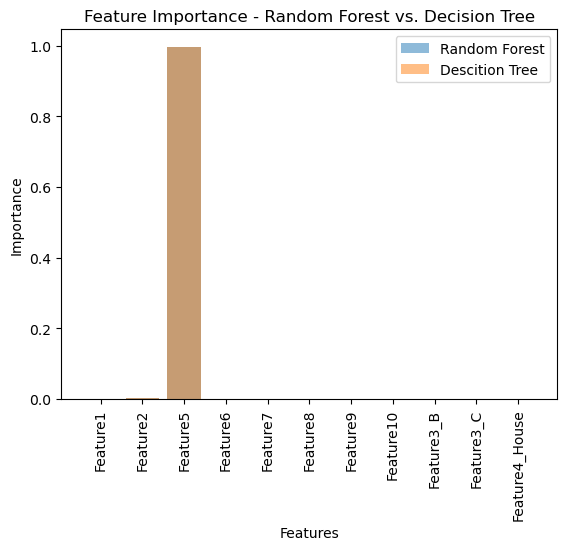

In [45]:
# plot feature importance of random forest vs single tree in the same plot
plt.bar(x.columns, best_rf_reg.feature_importances_, alpha=0.5, label="Random Forest")
plt.bar(x.columns, best_dt_reg.feature_importances_, alpha=0.5, label="Descition Tree")

plt.title("Feature Importance - Random Forest vs. Decision Tree")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=90)
plt.legend()
plt.show()


### Results

In [46]:
sorted_mae = mae_df.loc['MAE'].sort_values(ascending=True).astype(float)
sorted_mae.index

Index(['PR', 'RandomForest', 'DecisionTree', 'LR'], dtype='object')

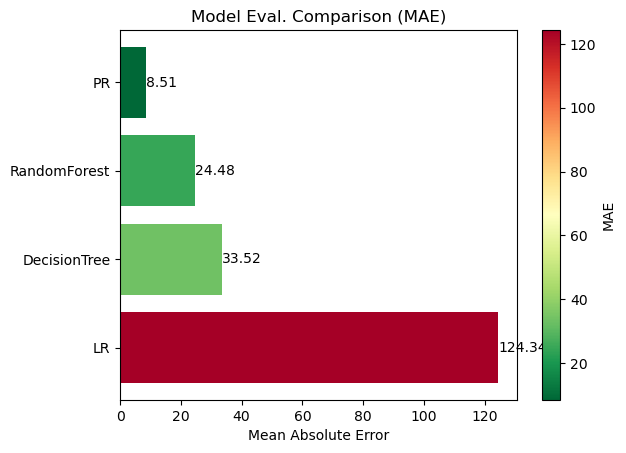

In [47]:
# plotting mae_df
fig, ax = plt.subplots()
y_pos = np.arange(len(mae_df.columns))

# Normalize values for colormap
norm = plt.Normalize(sorted_mae.min(), sorted_mae.max())
colors = plt.cm.RdYlGn_r(norm(sorted_mae))  # Red to Green colormap


ax.barh(y_pos, sorted_mae, align='center', color = colors)
# Add bar values on top
for i, v in enumerate(sorted_mae):
    ax.text(v + 0.1, i, f'{v:.2f}', va='center')

ax.set_yticks(y_pos, labels=sorted_mae.index)
ax.invert_yaxis() 
ax.set_xlabel('Mean Absolute Error')
ax.set_title('Model Eval. Comparison (MAE)')

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn_r'), ax=ax, label='MAE')  # Add colorbar


plt.show()

The chart above shows Polynominal Regression has the least MAE and thus can predict price best

Let's try to improve the second best model - Random Forst - using Grid Search

In [48]:
# Improving even more Random Forest Model: Grid Search the best parameters
from sklearn.model_selection import GridSearchCV
grid_params = {
'n_estimators' : [10, 1101, 100],
'max_depth' : [2,50,10],
'min_samples_split' : [2,5,10]
}
# new RF model
gs_rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gs_rf, param_grid=grid_params, cv = 5, n_jobs = -1)
grid_search.fit(x_train,y_train)

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print(best_params)

{'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 1101}


In [49]:
# model evaluation
y_pred = best_rf.predict(x_test)
best_mae = mean_absolute_error(y_test, y_pred)

In [50]:
best_mae

25.207858080614898

## Final Results

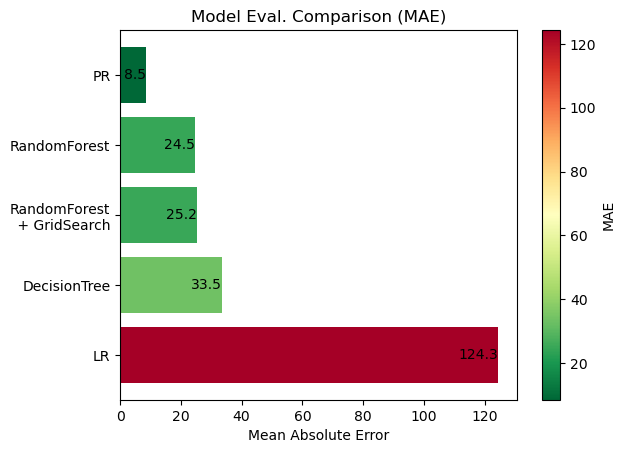

In [51]:
# update final results!
mae_df.loc['MAE', 'RandomForest\n + GridSearch'] = best_mae
    
sorted_mae = mae_df.loc['MAE'].sort_values(ascending=True).astype(float)

# plotting mae_df
fig, ax = plt.subplots()
y_pos = np.arange(len(mae_df.columns))

# Normalize values for colormap
norm = plt.Normalize(sorted_mae.min(), sorted_mae.max())
colors = plt.cm.RdYlGn_r(norm(sorted_mae))  # Red to Green colormap


ax.barh(y_pos, sorted_mae, align='center', color = colors)
# Add bar values on top
for i, v in enumerate(sorted_mae):
    ax.text(v + 0.1, i, f'{v:.1f}', va='center', ha='right') 

ax.set_yticks(y_pos, labels=sorted_mae.index)
ax.invert_yaxis() 
ax.set_xlabel('Mean Absolute Error')
ax.set_title('Model Eval. Comparison (MAE)')

plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='RdYlGn_r'), ax=ax, label='MAE')  # Add colorbar


plt.show()

Ploynominal Regression is still the best at predicting price, let's use it to predict price on the test dataset.

## Predicting price, submiting results
Note: the test dataset has no missing values (as a given) 

In [52]:
# load test data
test_data = pd.read_excel('data/herring_price_test.xlsx')

In [53]:
test_data.head()

Feature1  Feature2 Feature3   Feature4  Feature5  Feature6  Feature7  \
0  2.823211  5.803662        C  Apartment  4.421182  5.526196  2.863494   
1  3.665470  4.805474        A  Apartment  3.039118  4.292685  3.366858   
2  3.518963  4.273423        C  Apartment  3.849159  3.224850  2.488274   
3  3.011322  5.201014        B  Apartment  5.772018  5.907127  2.984993   
4  1.585269  4.604461        B      House  4.569089  5.612635  2.480834   

   Feature8  Feature9  Feature10        Price  
0  2.031203  2.018017   2.472630  1076.029226  
1  2.592567  4.704392   2.629885   447.907211  
2  2.633327  2.022631   3.405563   722.956938  
3  2.198680  2.079067   2.579124  2124.579172  
4  2.696168  2.517693   2.088091  1172.270551

In [54]:
# transform test data to match training data
test_data = test_data.drop(columns = ['Price'])
x_true_test = pd.get_dummies(test_data, columns=["Feature3", 'Feature4'], drop_first=True,dtype = int)
x_true_test.head()

Feature1  Feature2  Feature5  Feature6  Feature7  Feature8  Feature9  \
0  2.823211  5.803662  4.421182  5.526196  2.863494  2.031203  2.018017   
1  3.665470  4.805474  3.039118  4.292685  3.366858  2.592567  4.704392   
2  3.518963  4.273423  3.849159  3.224850  2.488274  2.633327  2.022631   
3  3.011322  5.201014  5.772018  5.907127  2.984993  2.198680  2.079067   
4  1.585269  4.604461  4.569089  5.612635  2.480834  2.696168  2.517693   

   Feature10  Feature3_B  Feature3_C  Feature4_House  
0   2.472630           0           1               0  
1   2.629885           0           0               0  
2   3.405563           0           1               0  
3   2.579124           1           0               0  
4   2.088091           1           0               1

In [55]:
x_true_test_poly = best_poly_ft.transform(x_true_test)
y_ans = best_poly_reg.predict(x_true_test_poly)
y_ans

array([1076.02922607,  447.90721133,  722.95693778, 2124.57917239,
       1172.27055064,  812.49285583, 2039.2612779 , 2176.20025271,
       1540.11256669, 1907.17843621,  680.61494215,  691.22093665,
        694.55175937,  700.02654152, 1852.59889188,  225.2472954 ,
        625.39347846, 1122.12748309, 2832.35783876,  425.36151933,
        323.52390165,  976.29239939,  923.95334488,  369.67715209,
        856.84156004, 1215.37918483, 1118.03843534,  878.75750426,
        131.59530689,  732.1401881 , 2983.69415859,  857.57787724,
       1661.72677299,  731.31828981,  936.49417047,  718.81635848,
        787.19168985,  689.86199287,  867.04853837, 1267.36526135,
       1021.35276708,  566.21304959,  858.178501  , 1778.52298326,
        967.52112753, 2092.26064473,  995.32713008, 1085.30368009,
       1183.52990899,  870.31121267,  377.90132957,  680.39202481,
        288.88021212, 1013.02240436, 1881.33530607,  566.60631361,
        851.93965646, 1954.73998641,  558.58387602, 1402.33617

In [56]:
# save the results to a csv file
y_ans_df = pd.DataFrame(y_ans, columns = ['Price'])
y_ans_df.to_csv('data/herring_price_test_ans_pol.csv', index=False)